# Прогнозирование оттока клиентов "Ниединогоразрыва.ком"

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных вида услуг: стационарную телефонную связь и интернет, кроме того доступен ряд дополнительных услуг, например стриминоговое телевидение или облачное хранилище. Клиенты могут платить каждый месяц или заключить договор на 1–2 года. 

В нашем распоряжении файлы с информацией о договоре, персональными данными клиента, информацией об интернет-услугах и услугах телефонии. Файлы связаны между собой через ID клиента. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1">Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.1">Знакомство с данными</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1.1">Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2">Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2.1">Вывод</a></span></li></ul></li><li><span><a href="#Получение-срезов" data-toc-modified-id="Получение-срезов-1.3">Получение срезов</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3.1">Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-1.4">Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4.1">Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-1.5">Общий вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2">Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.1">Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2">Случайный лес</a></span></li><li><span><a href="#Использование-градиентного-бустинга-CatBoost" data-toc-modified-id="Использование-градиентного-бустинга-CatBoost-2.3">Использование градиентного бустинга CatBoost</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3">Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1">Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-итоговой-модели" data-toc-modified-id="Тестирование-итоговой-модели-4">Тестирование итоговой модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5">Вывод</a></span></li><li><span><a href="#Отчёт" data-toc-modified-id="Отчёт-6">Отчёт</a></span></li></ul></div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

## Исследовательский анализ данных

### Знакомство с данными

Загрузим данные из файлов:

In [2]:
contract = pd.read_csv("/contract.csv")
personal = pd.read_csv("/personal.csv")
internet = pd.read_csv("/internet.csv")
phone = pd.read_csv("/phone.csv")

Посмотрим на имеющиеся данные:

In [4]:
for table in [contract, personal, internet, phone]:
    display(table.sample(n=5, random_state = 123))
    table.info()
    display(table.describe(include = 'all').T)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
941,0811-GSDTP,2019-01-01,No,Month-to-month,No,Electronic check,30.15,382.2
1404,1970-KKFWL,2017-03-01,No,Two year,No,Bank transfer (automatic),23.30,797.1
5515,2892-GESUL,2018-08-01,No,Two year,No,Mailed check,19.35,309.25
3684,2842-BCQGE,2016-07-01,No,Month-to-month,Yes,Credit card (automatic),75.35,3161.4
7017,4807-IZYOZ,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6531,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,customerID,gender,SeniorCitizen,Partner,Dependents
941,0811-GSDTP,Female,0,No,Yes
1404,1970-KKFWL,Female,0,No,No
5515,2892-GESUL,Female,0,Yes,Yes
3684,2842-BCQGE,Male,0,No,No
7017,4807-IZYOZ,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2730,4682-BLBUC,DSL,No,Yes,Yes,Yes,Yes,No
4071,7668-XCFYV,Fiber optic,No,No,No,No,Yes,Yes
137,6727-IOTLZ,DSL,No,Yes,Yes,Yes,Yes,Yes
724,2719-BDAQO,Fiber optic,Yes,No,No,No,Yes,Yes
3821,1394-SUIUH,Fiber optic,Yes,Yes,No,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


,customerID,MultipleLines
1868,8543-MSDMF,No
1896,7228-PAQPD,No
4150,3709-OIJEA,No
5335,2296-DKZFP,No
4728,2983-ZANRP,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


#### Вывод

Почти все данные представлены в виде строк. В нашем распоряжении данные о социальном статусе человека, о его контракте и опциях, которые он подключил для услуг телефона и интернета. Целевым признаком, который модели нужно будет предсказать, является то, ушёл клиент или нет.

### Предобработка данных

Заменим типы данных на более подходящие:

In [5]:
#преобразование данных в талице contract
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')
contract['PaperlessBilling'] = contract['PaperlessBilling'].replace({'Yes': 1, 'No':0}).astype('bool')

#переведем данные об объеме платежей в числовой формат
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')

#преобразование данных в таблице personal
personal['gender'].replace({'Female':0, 'Male':1}, inplace = True)
for name in ['Partner', 'Dependents']:
    personal[name].replace({'Yes': 1, 'No':0}, inplace = True)
for name in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    personal[name] = personal[name].astype('bool')

#преобразование данных в таблице internet
for name in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[name].replace({'Yes': 1, 'No':0}, inplace = True)
    internet[name] = internet[name].astype('bool')

#преобразование данных в таблице phone   
phone['MultipleLines'].replace({'Yes': 1, 'No':0}, inplace = True)
phone['MultipleLines'] = phone['MultipleLines'].astype('bool')

Посмотрим, что было в строках с нечисловым значением общего объема платежей:

In [7]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,False,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,False,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,False,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,False,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,False,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,False,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,False,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,False,Mailed check,73.35,NaN


У 11 человек, оформивших контракт в феврале 2020 года, вместо суммарного количества заплаченных ими средств стояла пустая строка. Посмотрим, заключил ли кто-то ещё в этом месяце контракт:

In [8]:
contract[contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,True,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,False,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,False,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,False,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,False,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,False,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,False,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,False,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,True,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,False,Mailed check,73.35,NaN


В феврале 2020 подключились только эти пользователи. Проверим, не последний ли это месяц, за который у нас имеются данные:

In [9]:
contract['BeginDate'].value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

Это действительно последний месяц. Значит, скорее всего, эти пользователи ещё не успели ни разу заплатить. Можно заполнить пропущенные значения нулями:

In [10]:
contract['TotalCharges'].fillna(0.0, inplace = True)

#### Вывод

Данные, записанные в виде строк, были переведены в форматы, в которых с ними удобно будет работать. Пропущенные значения суммарной оплаты были заменены нулями.

### Получение срезов

Объединим таблицы personal и contract, а также добавим в получившуюся таблицу два столбца: пользуется ли человек телефонией и пользуется ли человек интернетом:

In [11]:
df = personal.merge(contract, on = 'customerID')
df['internet'] = df['customerID'].isin(internet['customerID'])
df['phone'] = df['customerID'].isin(phone['customerID'])

Теперь для каждой из трёх получившихся таблиц (df, internet, phone) создадим два среза: люди, которые ещё пользуются услугами оператора и те, кто перестал:

In [12]:
#делаем срезы для таблицы df
df_noend = df[df['EndDate'] == 'No']
df_end = df[df['EndDate'] != 'No']

#делаем срезы для таблицы internet
internet_noend = internet[internet['customerID'].isin(df_noend['customerID'])]
internet_end = internet[internet['customerID'].isin(df_end['customerID'])]

#делаем срезы для таблицы phone
phone_noend = phone[phone['customerID'].isin(df_noend['customerID'])]
phone_end = phone[phone['customerID'].isin(df_end['customerID'])]

В таблицах df заменим столбцы BeginDate и EndDate на общее время использования услуг оператора в месяцах.

In [13]:
df_noend['EndDate'] = pd.to_datetime(df_noend['EndDate'].replace({'No':'2020-02-01'}))
df_end['EndDate'] = pd.to_datetime(df_end['EndDate'])

df_end['Time'] = (df_end['EndDate'].dt.to_period('M').astype(int) - df_end['BeginDate'].dt.to_period('M').astype(int))
df_noend['Time'] = (df_noend['EndDate'].dt.to_period('M').astype(int) - df_noend['BeginDate'].dt.to_period('M').astype(int))

df_end.drop(['BeginDate', 'EndDate'], inplace = True, axis = 1)
df_noend.drop(['BeginDate', 'EndDate'], inplace = True, axis = 1)

C:\Users\dielo\AppData\Local\Temp\ipykernel_17468\2075917225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noend['EndDate'] = pd.to_datetime(df_noend['EndDate'].replace({'No':'2020-02-01'}))
C:\Users\dielo\AppData\Local\Temp\ipykernel_17468\2075917225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end['EndDate'] = pd.to_datetime(df_end['EndDate'])
C:\Users\dielo\AppData\Local\Temp\ipykernel_17468\2075917225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

#### Вывод

Получили срезы для каждой из таблиц, чтобы исследовать, что влияет на целевой признак (ушёл клиент или нет).

### Анализ

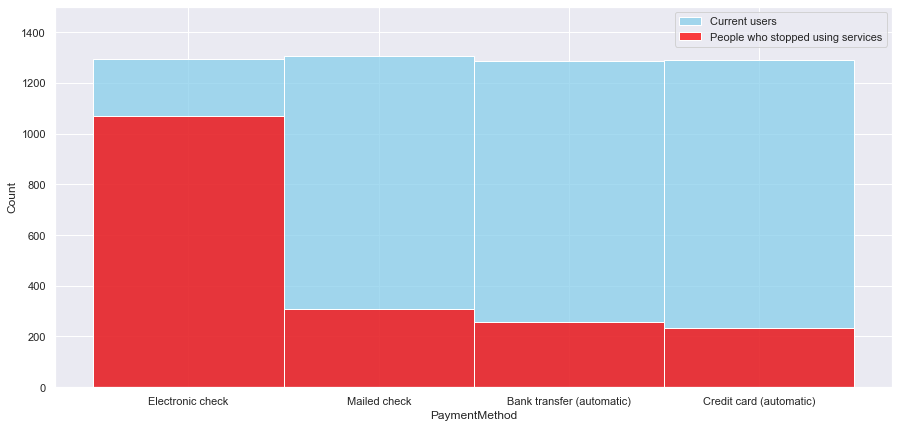

In [14]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 7]
plt.ylim(0, 1500)
sns.histplot(data=df_noend, x="PaymentMethod", color="skyblue", 
             label="Current users", kde=False, line_kws={'alpha':0.01})
sns.histplot(data=df_end, x="PaymentMethod", color="red", 
             label="People who stopped using services", kde=False, line_kws={'alpha':0.01})

plt.legend() 
plt.show()

Тогда как методы оплаты между нынешними пользователями распределены равномерно, большинство тех, кто прекратил пользоваться услугами оператора, пользовались электронным чеком.

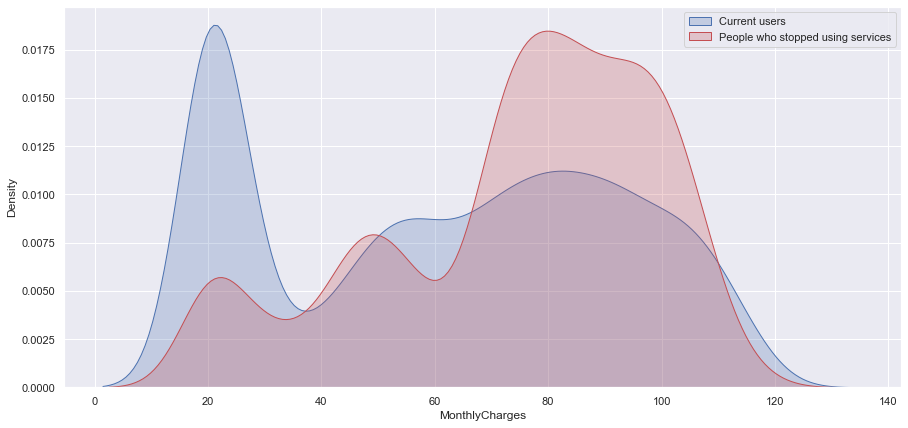

In [15]:
fig = sns.kdeplot(df_noend['MonthlyCharges'], shade=True, color="b", 
             label="Current users")
fig = sns.kdeplot(df_end['MonthlyCharges'], shade=True, color="r", label="People who stopped using services")
plt.legend() 
plt.show()

Пики на обоих графиках примерно совпадают (скорее всего они соответсвуют самым популярным наборам услуг), однако среди нынешних пользователей гораздо более распространено брать меньшее количество услуг за меньшую плату, тогда как ушедшие пользователи в основном платили много денег ежемесячно.

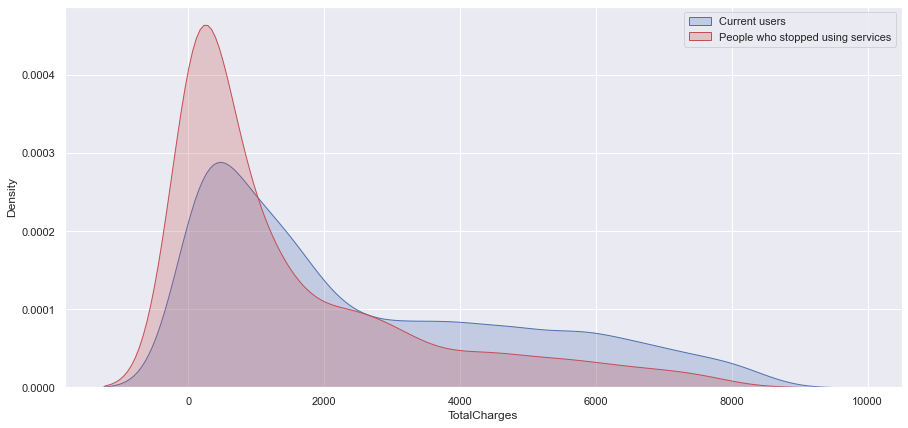

In [16]:
fig = sns.kdeplot(df_noend['TotalCharges'], shade=True, color="b", 
             label="Current users")
fig = sns.kdeplot(df_end['TotalCharges'], shade=True, color="r", label="People who stopped using services")
plt.legend() 
plt.show()

Оба графика представляют собой нормальное распределение с тяжелым хвостом. Среди ушедших пользователей больший процент людей в сумме заплатили не так много (скорее всего потому что достаточно быстро ушли).

In [17]:
print('Percent of current users, who use internet: {:.2%}'.format(df_noend['internet'].mean()))
print('Percet of former users, who used internet: {:.2%}'.format(df_end['internet'].mean()))
print()
print('Percent of current users, who use phone: {:.2%}'.format(df_noend['phone'].mean()))
print('Percet of former users, who used internet: {:.2%}'.format(df_end['phone'].mean()))

Percent of current users, who use internet: 72.69%
Percet of former users, who used internet: 93.95%

Percent of current users, who use phone: 90.10%
Percet of former users, who used internet: 90.90%


Телефон используют почти все нынешние и бывшие пользователи, однако среди тех, кто перестал пользоваться услугами оператора, больше людей использовали в том числе интернет.

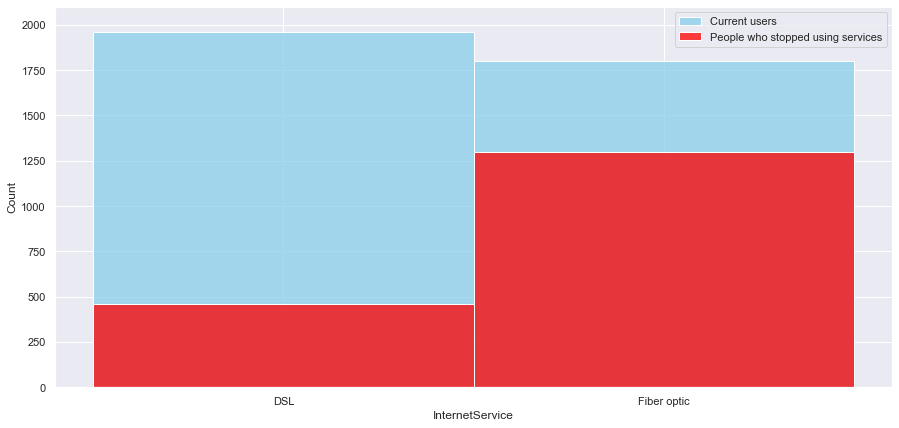

In [18]:
plt.rcParams['figure.figsize'] = [15, 7]
plt.ylim(0, 2100)
sns.histplot(data=internet_noend, x='InternetService', color="skyblue",
             label="Current users", kde=False)
sns.histplot(data=internet_end, x='InternetService', color="red", 
             label="People who stopped using services", kde=False)
plt.legend()
plt.show()

In [19]:
for name in ['OnlineSecurity', 'OnlineBackup', 
             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    print(name)
    print('Percent of current users, who use this service: {:.2%}'.format(internet_noend[name].mean()))
    print('Percet of former users, who used this servise: {:.2%}'.format(internet_end[name].mean()))
    print()
    
print('MultipleLines')
print('Percent of current users, who use this service: {:.2%}'.format(phone_noend['MultipleLines'].mean()))
print('Percet of former users, who used this servise: {:.2%}'.format(phone_end['MultipleLines'].mean()))

OnlineSecurity
Percent of current users, who use this service: 45.84%
Percet of former users, who used this servise: 16.80%

OnlineBackup
Percent of current users, who use this service: 50.68%
Percet of former users, who used this servise: 29.78%

DeviceProtection
Percent of current users, who use this service: 49.91%
Percet of former users, who used this servise: 31.04%

TechSupport
Percent of current users, who use this service: 46.10%
Percet of former users, who used this servise: 17.65%

StreamingTV
Percent of current users, who use this service: 50.33%
Percet of former users, who used this servise: 46.36%

StreamingMovies
Percent of current users, who use this service: 50.89%
Percet of former users, who used this servise: 46.58%

MultipleLines
Percent of current users, who use this service: 45.50%
Percet of former users, who used this servise: 50.03%


Несмотря на то, что ушедшие пользователи больше платили за месяц, дополнительными услугами чаще пользуются нынешние пользователи. Возможно, цена была обусловлена тем, что ушедшие пользователи чаще брали оптоволоконный интернет.
Посмотрим, зависит ли то, ушёл пользователь или нет, от его пола, семейного положения и того, явяется ли он пенсионером:

In [20]:
print('Percent of men among current users: {:.2%}'.format(df_noend['gender'].mean()))
print('Percent of men among format users: {:.2%}'.format(df_end['gender'].mean()))

Percent of men among current users: 50.73%
Percent of men among format users: 49.76%


In [21]:
print('Percent of senior sitizen among current users: {:.2%}'.format(df_noend['SeniorCitizen'].mean()))
print('Percent of senior sitizen among format users: {:.2%}'.format(df_end['SeniorCitizen'].mean()))

Percent of senior sitizen among current users: 12.87%
Percent of senior sitizen among format users: 25.47%


In [22]:
print('Percent of not single people among current users: {:.2%}'.format(df_noend['Partner'].mean()))
print('Percent of not single people among format users: {:.2%}'.format(df_end['Partner'].mean()))

Percent of not single people among current users: 52.82%
Percent of not single people among format users: 35.79%


In [23]:
print('Percent of people with dependents among current users: {:.2%}'.format(df_noend['Dependents'].mean()))
print('Percent of people with dependents among format users: {:.2%}'.format(df_end['Dependents'].mean()))

Percent of people with dependents among current users: 34.48%
Percent of people with dependents among format users: 17.44%


Пенсионеры, одинокие люди и люди без детей чаще отказываются от услуг оператора. Пол же не имеет значительного влияния, можно не включать его в признаки для обучения модели.

Объединим все признаки в одну таблицу и проверим их мультикорреляцию:

In [24]:
df_end['is_current_user'] = 0
df_noend['is_current_user'] = 1
df = pd.concat([df_end, df_noend]).sample(frac = 1, random_state = 8).reset_index().drop('index', axis = 1)
df = df.merge(internet, how = 'outer')
df = df.merge(phone, how = 'outer')

C:\Users\dielo\AppData\Local\Temp\ipykernel_17468\3226523979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end['is_current_user'] = 0
C:\Users\dielo\AppData\Local\Temp\ipykernel_17468\3226523979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noend['is_current_user'] = 1


In [25]:
df.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
internet               0
phone                  0
Time                   0
is_current_user        0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [26]:
df['InternetService'].replace({'Fiber optic': 1, 'DSL': 0}, inplace = True)
for col in (list(internet.drop('customerID', axis = 1).columns) + 
            list(phone.drop('customerID', axis = 1).columns)):
    df[col] = df[col].fillna(-1).astype('int8')
for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']:
    df[col] = df[col].astype('int8')
df['Type'].replace({'Month-to-month':0, 'One year': 1, 'Two year':2}, inplace = True)
df['PaymentMethod'].replace({'Mailed check':0, 'Credit card (automatic)':1, 
                             'Bank transfer (automatic)': 2, 'Electronic check': 3}, inplace = True)

In [27]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,...,Time,is_current_user,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,8280-MQRQN,0,0,0,0,0,1,0,50.45,50.45,...,1,0,0,0,0,1,0,0,0,0
1,7251-XFOIL,0,0,0,0,0,0,0,89.20,5500.60,...,61,1,1,0,0,1,0,0,1,1
2,0513-RBGPE,1,0,1,1,2,1,1,62.80,2278.75,...,37,1,0,1,0,1,1,0,0,1
3,6497-TILVL,0,0,1,1,0,0,0,50.70,350.35,...,7,1,0,1,0,0,0,0,0,0
4,2578-JQPHZ,1,0,0,0,2,0,2,100.10,4378.35,...,44,1,1,0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2233-FAGXV,0,0,1,1,0,1,0,24.30,132.25,...,5,1,-1,-1,-1,-1,-1,-1,-1,1
7039,1853-ARAAQ,0,0,0,0,0,1,1,50.35,1277.50,...,26,1,0,0,0,1,0,1,1,-1
7040,9286-BHDQG,1,0,1,1,2,0,1,45.25,3139.80,...,72,1,0,1,1,1,1,0,0,-1
7041,8382-SHQEH,0,0,1,0,0,1,3,84.90,764.95,...,8,0,1,0,0,0,0,0,1,1


<AxesSubplot:>

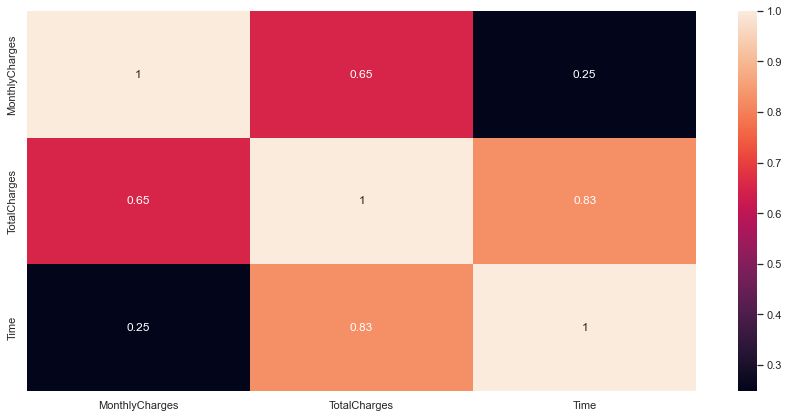

In [28]:
sns.heatmap(df[['MonthlyCharges', 'TotalCharges', 'Time']].corr(), annot = True)

Сильной корреляции между признаками не наблюдается.

Уберем столбцы, которые не нужно включать в обучение модели:

In [29]:
df.drop(['customerID', 'gender'], axis = 1, inplace = True)

#### Вывод

Достаточно часто уходят пользователи, которые пользуются помимо телефона ещё и интернетом (часто оптоволоконным), возможно стоит обратить внимание на качество этой услуги.

Была проверена мультикорреляция признаков и составлена итоговая таблица для обучения моделей машинного обучения.

### Общий вывод

Были проведены ознакомление с задачей, предобработка и исследовательский анализ данных.

Дальнейший план работы:
1. Обучение нескольких моделей с различными гиперпараметрами.
2. Анализ полученных моделей и выбор наиболее подходящей.
3. Тестирование итоговой модели.

## Обучение моделей

Перед нами стоит задача классификации. Для её решения можно попробовать применить модели дерева решений, случайного леса, а также градиентный бустинг CatBoost. 

Для каждой из полученных моделей будем измерять AUC-ROC и accuracy.

Выделим целевой признак:

In [30]:
target = df['is_current_user']
features = df.drop('is_current_user', axis = 1)

Проверим распределение классов:

In [31]:
target.mean()

0.7346301292063041

Сильного дисбаланса классов не наблюдается.

Выделим тестовую выборку:

In [32]:
features, features_test, target, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 42, stratify = target)

### Дерево решений

In [33]:
best_auc_roc = 0
best_depth = 0
for i in range (1,11):
    model = DecisionTreeClassifier(random_state = 8, max_depth = i)
    auc_roc = sum(cross_val_score(model, features, target, cv = 10, scoring = 'roc_auc'))/10
    if auc_roc > best_auc_roc:
        best_auc_roc = auc_roc
        best_tree = model
        best_depth = i
        
print(best_auc_roc, best_depth)

0.828131333918295 5


In [34]:
final = pd.DataFrame(columns = ['Модель',  'AUC-ROC', 'accuracy'])

In [35]:
final_ = pd.DataFrame([['Дерево решений', sum(cross_val_score(best_tree, features, target, cv = 10, scoring = 'roc_auc'))/10, 
                        sum(cross_val_score(best_tree, features, target, cv = 10, scoring = 'accuracy'))/10]], columns = final.columns)

In [36]:
final = pd.concat([final, final_])

In [37]:
final

,Модель,AUC-ROC,accuracy
0,Дерево решений,0.828131,0.78647


### Случайный лес

In [38]:
forest = RandomForestClassifier(random_state = 12345)

In [39]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
rs = RandomizedSearchCV(forest, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

In [41]:
rs.fit(features, target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0, verbose=1)

In [42]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

In [43]:
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,100,10,5,sqrt,11,True,0.805289,1
1,100,9,5,log2,11,True,0.805289,1
2,200,6,6,sqrt,10,True,0.804757,3
3,300,5,9,log2,14,True,0.803869,4
4,700,5,5,log2,6,True,0.803337,5
5,500,3,2,sqrt,7,False,0.803337,5
6,300,4,8,sqrt,15,True,0.803159,7
7,700,6,8,log2,11,True,0.803159,8
8,400,7,7,log2,9,False,0.802982,9
9,200,2,9,log2,10,True,0.802982,9


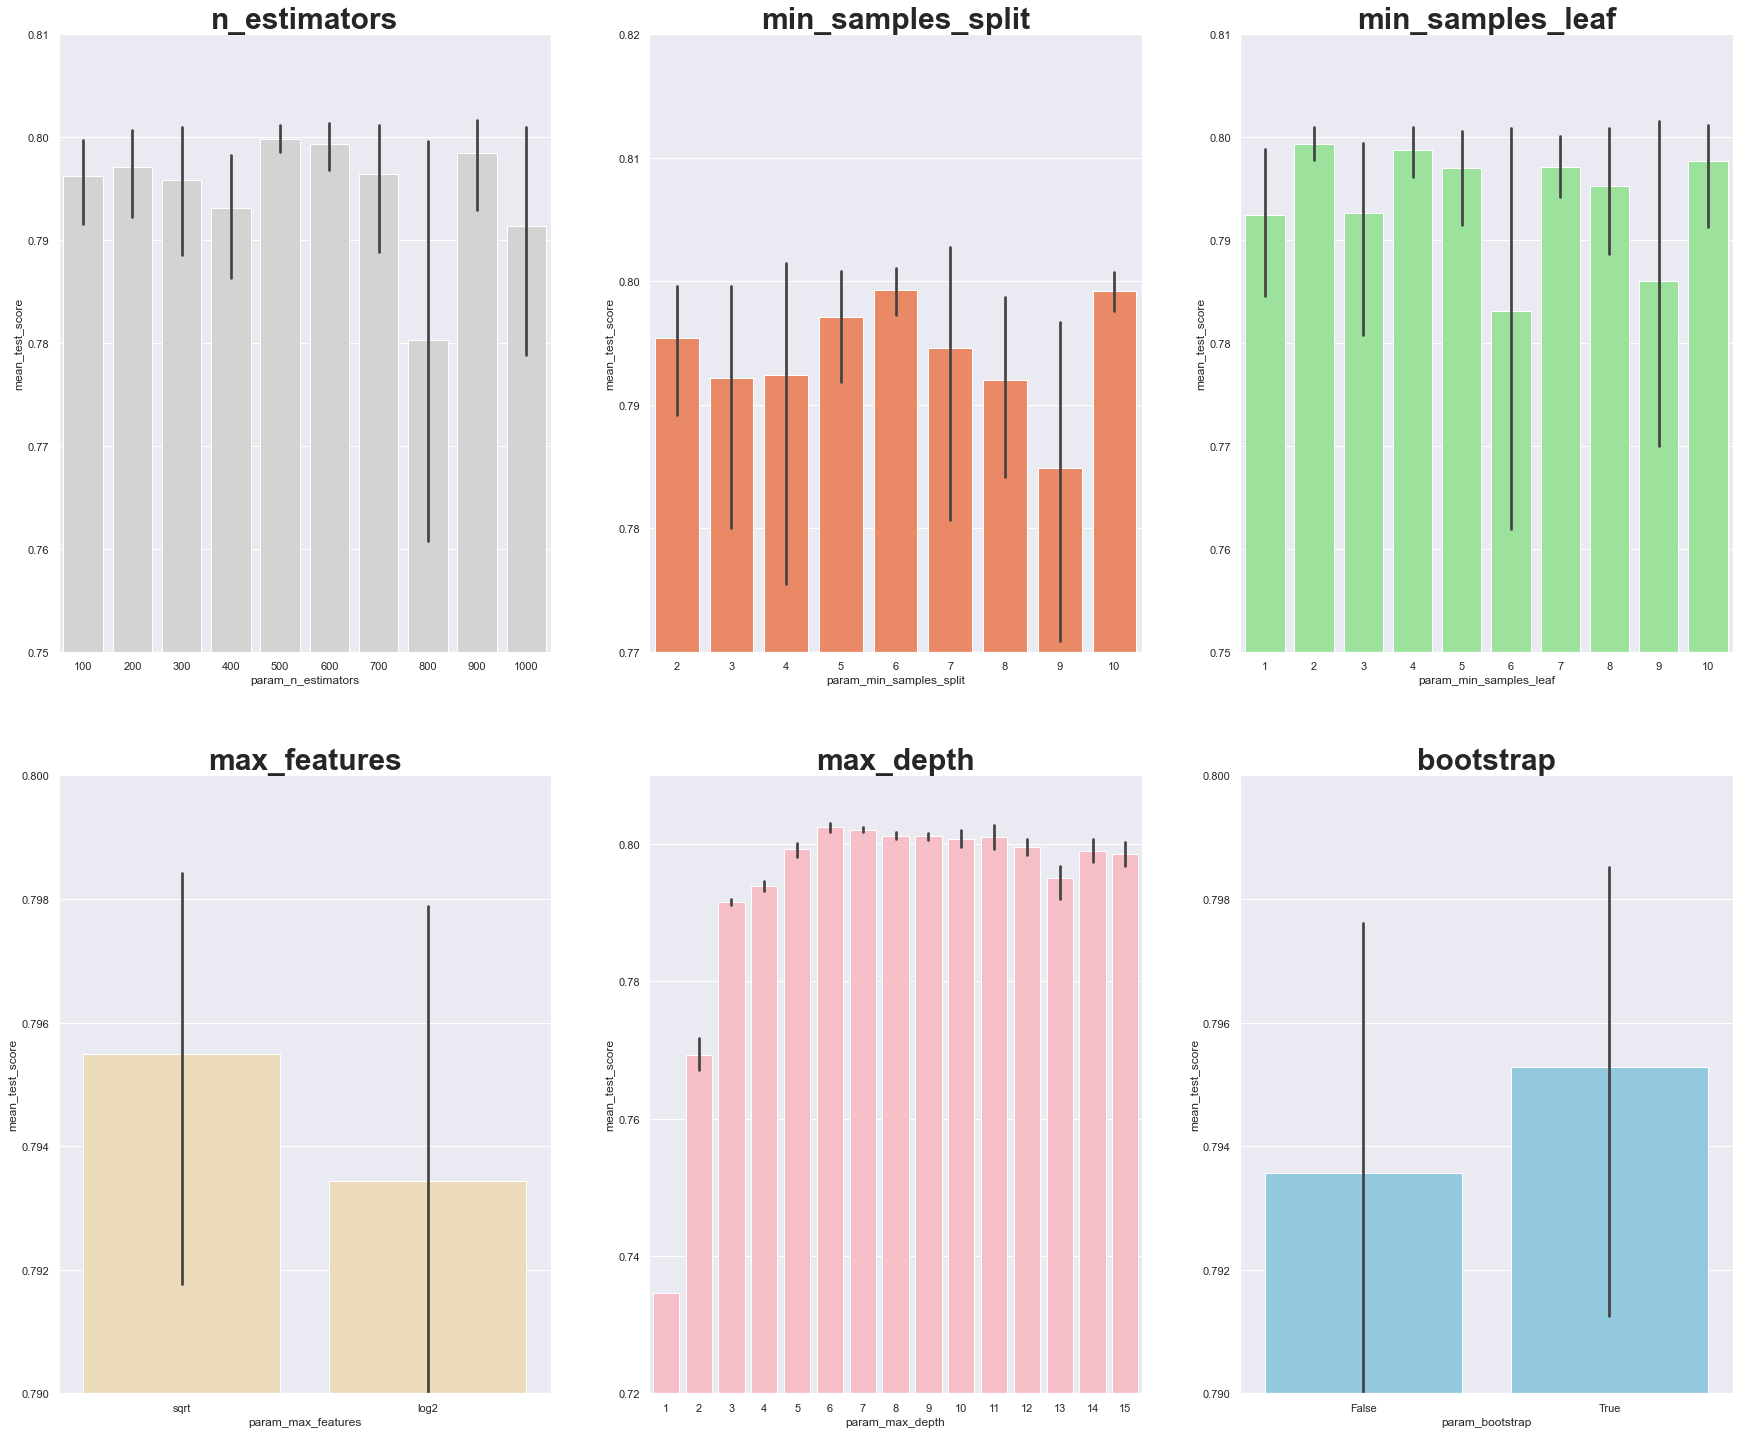

In [44]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.75,.81])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.77,.82])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.75,.81])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.79,.80])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.72,.81])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.79,.80])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [45]:
n_estimators = [500]
max_features = ['sqrt']
max_depth = [7, 8]
min_samples_split = [6, 10]
min_samples_leaf = [2, 4, 5]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [46]:
gs = GridSearchCV(forest, param_grid, cv = 3, verbose = 1, n_jobs=-1)

In [47]:
gs.fit(features, target)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [7, 8],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4, 5],
                         'min_samples_split': [6, 10], 'n_estimators': [500]},
             verbose=1)

In [48]:
best_forest = gs.best_estimator_

In [49]:
final_ = pd.DataFrame([['Случайный лес', sum(cross_val_score(best_forest, features, target, cv = 10, scoring = 'roc_auc'))/10, 
                        sum(cross_val_score(best_forest, features, target, cv = 10, scoring = 'accuracy'))/10]], columns = final.columns)

In [50]:
final = pd.concat([final, final_])

In [51]:
final

,Модель,AUC-ROC,accuracy
0,Дерево решений,0.828131,0.78647
0,Случайный лес,0.844326,0.800671


### Использование градиентного бустинга CatBoost

In [52]:
cat_features = features.drop(['Time', 'TotalCharges', 'MonthlyCharges'], axis = 1).columns.tolist()

In [53]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify=target)

In [54]:
train_pool = Pool(data = features_train, label = target_train, cat_features=cat_features)
valid_pool = Pool(data = features_valid, label = target_valid, cat_features=cat_features)
pool = Pool(data = features, label = target, cat_features=cat_features)

In [55]:
cat = CatBoostClassifier(iterations = 2000, eval_metric = 'AUC',loss_function='CrossEntropy', learning_rate = 0.03,
                         depth = 1, l2_leaf_reg = 8,
                         random_seed = 42)

In [56]:
cat.fit(train_pool, 
                use_best_model=True, 
                eval_set=valid_pool,
                verbose = 0, plot = True
                )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
final_ = pd.DataFrame([['Ансамбль CatBoost', cat.best_score_['validation']['AUC'], 
                        accuracy_score(target_valid, cat.predict(features_valid))]], columns = final.columns)

In [58]:
final = pd.concat([final, final_])

In [59]:
cat = CatBoostClassifier(iterations = 1731, eval_metric = 'AUC',loss_function='CrossEntropy', learning_rate = 0.03,
                         depth = 1, l2_leaf_reg = 8,
                         random_seed = 42)

In [60]:
cat.fit(pool)

0:	total: 7.28ms	remaining: 12.6s
1:	total: 13.7ms	remaining: 11.8s
2:	total: 23.5ms	remaining: 13.5s
3:	total: 33ms	remaining: 14.3s
4:	total: 39.7ms	remaining: 13.7s
5:	total: 50ms	remaining: 14.4s
6:	total: 60.2ms	remaining: 14.8s
7:	total: 69.7ms	remaining: 15s
8:	total: 79.1ms	remaining: 15.1s
9:	total: 89.7ms	remaining: 15.4s
10:	total: 101ms	remaining: 15.7s
11:	total: 111ms	remaining: 15.9s
12:	total: 121ms	remaining: 16s
13:	total: 131ms	remaining: 16.1s
14:	total: 143ms	remaining: 16.4s
15:	total: 156ms	remaining: 16.7s
16:	total: 168ms	remaining: 17s
17:	total: 180ms	remaining: 17.1s
18:	total: 190ms	remaining: 17.2s
19:	total: 206ms	remaining: 17.7s
20:	total: 217ms	remaining: 17.7s
21:	total: 228ms	remaining: 17.7s
22:	total: 239ms	remaining: 17.7s
23:	total: 249ms	remaining: 17.7s
24:	total: 259ms	remaining: 17.7s
25:	total: 270ms	remaining: 17.7s
26:	total: 280ms	remaining: 17.7s
27:	total: 290ms	remaining: 17.6s
28:	total: 299ms	remaining: 17.6s
29:	total: 311ms	remaini

## Анализ моделей

Были получены 3 различных модели машинного обучения. Посмотрим на сводную таблицу их характеристик:

In [61]:
final

,Модель,AUC-ROC,accuracy
0,Дерево решений,0.828131,0.78647
0,Случайный лес,0.844326,0.800671
0,Ансамбль CatBoost,0.842068,0.808375


### Вывод

У модели случайного леса и ансамбля CatBoost почти совпадают обе метрики. Однако, скорее всего ансамбль будет лучше работать с новыми данными.

## Тестирование итоговой модели

В качестве итоговой модели был выбран ансамбль CatBoost. Проверим его качество на тестовой выборке:

In [62]:
roc_auc_score(target_test, cat.predict_proba(features_test)[:, 1])

0.8552545919553594

In [63]:
accuracy_score(target_test, cat.predict(features_test))

0.801277501774308

<AxesSubplot:>

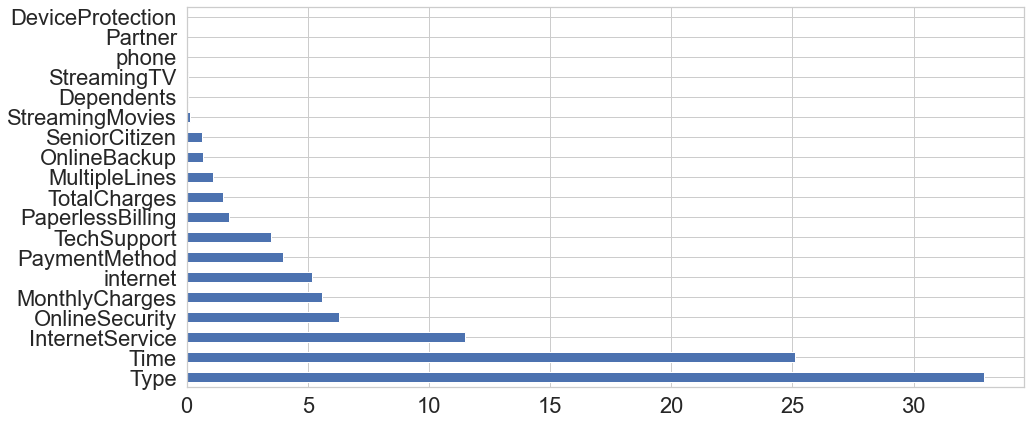

In [66]:
feat_importances = pd.Series(cat.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Вывод

Был проведен анализ данных и выявлено, что:
1. В среднем ушедшие клиенты платили в месяц больше, чем оставшиеся
2. Большинство ушедших клиенов пользовались оптоволоконным интернетом

Были обучены несколько моделей машинного обучения для предсказания оттока клиентов. Для проверки качества моделей использовались метрики roc_auc и accuracy. Наилучшее качество показал ансамбль CatBoost.

AUC-ROC полученной модели на тестовой выборке - 0.8553, accuracy - 0.8013.

Самыми важными признаками для качества модели оказались тип контракта и время пользования услугами оператора. Признаки, не влияющие на качество модели (а значит, и на уход пользователя) - есть ли у человека партнер, дети, подключено ли у него стриминговое ТВ.

## Отчёт

Составленный на основе анализа данных план:
1. Обучение нескольких моделей с различными гиперпараметрами.
2. Анализ полученных моделей и выбор наиболее подходящей.
3. Тестирование итоговой модели.

Были выполнены все пункты этого плана, обучены три разных модели, далее проведен их анализ и выбранная модель проверена на тестовой выборке.

В процессе выполнения работы возникли следующие трудности:
1. При изначально предложенном мной способе обработки данных из таблиц internet и phone (люди, совсем не использующие услуги интернета и телефона помечались нулем, так же, как и люди, не использующие только конкретную дополнительную услугу) не удавалось достичь высокого качества моделей, поэтому я решила -1 вместо 0, что помогло повысить качество предсказаний.
2. Изначально я искала гиперпараметры для случайного леса только при помощи Grid Search и это занимало много времени и не давало хорошего результата. Проблема была решена поиском параметров при помощи сочетания Randomise Search и Grid Search.

Моя итоговая модель - ансамбль CatBoost со скоростью обучения 0.03 и 1731 итерацией обучения. Ее AUC-ROC на тестовой выборке - 0.8552, accuracy на тестовой выборке - 0.8013.